# Binary Matrix Completion in Julia
### [Alex Williams](http://alexhwilliams.info)

### Relevent papers

Mark A. Davenport, Yaniv Plan, Ewout van den Berg, Mary Wootters. [1-Bit Matrix Completion](http://arxiv.org/pdf/1209.3672v3.pdf) *Information and Inference* 3(3), 189-223. (2014)

### Relevent Code

**Github Repo**: [Convex.jl](https://github.com/JuliaOpt/Convex.jl)

**Paper**: Madeleine Udell, Karanveer Mohan, David Zeng, Jenny Hong, Steven Diamond, Stephen Boyd. [Convex Optimization in Julia](https://web.stanford.edu/~boyd/papers/pdf/convexjl.pdf). *SC14 Workshop on High Performance Technical Computing in Dynamic Languages*

### Math Notes

Let $Y$ be a binary matrix with missing entries. We will fit a model $Y \approx f(X)$, where $X$ is a matrix of real numbers and $f$ is a function that maps real numbers into probabilities, $\mathbf{R} \rightarrow [0,1]$, and is applied element-wise to $X$. Let $\Omega$ be the set of matrix indices $(i,j)$ that are observed in $Y$.

We will consider the case where $f(\cdot)$ is the logistic function:

$$f(x) = \frac{1}{1+\exp(-x)}$$

The log-likelihood function for a given estimate of $X$ is:

$$\mathcal{L}(X|Y) = \sum_\Omega \left [ \mathcal{I}_{Y_{ij} = 1} \log\left(f(X_{ij})\right) + \mathcal{I}_{Y_{ij} = -1} \log\left(1 -f(X_{ij})\right)  \right ]$$

Where $\mathcal{I}$ is the binary event indicator function. Because $f(-x) = 1-f(x)$ for the logistic function, the likelihood simplifies to:

$$\mathcal{L}(X|Y) = \sum_\Omega - \log \left [ 1 + \exp(-Y_{ij} X_{ij} )\right ]$$

Our goal is to maximize find an $X$ that maximizes the likelihood. However, the problem is under-determined due to the missing entries in $Y$. Thus, we search for an $X$ that is low-rank, which we achieve by imposing a nuclear norm constraint.

$$
\begin{aligned}
& \underset{X}{\text{minimize}}
& & \sum_{(i,j) \in \Omega} \log(1+\exp(-Y_{ij} (X_{ij})) \\
& \text{subject to}
& & ||X||_* \leq \gamma
\end{aligned}
$$


In [1]:
using PyPlot
using Convex
using SCS

# passing in verbose=0 to hide output from SCS
solver = SCSSolver(verbose=0)
set_default_solver(solver);

# logistic function
lgc(x) = 1 ./ (1+exp(-x));

INFO: Loading help data...


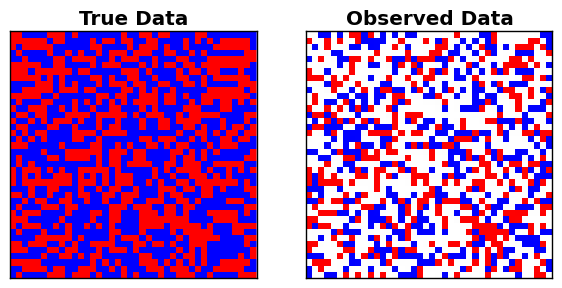

In [2]:
# Construct a random m-by-n binary matrix matrix
m,n,k = 40,40,2
M = randn(m,k)*randn(k,n)       # Underlying low-rank matrix
fM = lgc(M)                     # Probability matrix, maps M onto interval [0,1]
Y = map(x->x>rand()? 1 : -1,fM) # True data, binary matrix

# Suppose that we only observe a fraction of entries in Y
n_obs = 800
Yobs = fill(NaN,(m,n))
obs = randperm(m*n)[1:n_obs]
Yobs[obs] = Y[obs]

# Plot the ground-truth, full dataset and our partial observations
figure(figsize=(7,14))
subplot(1,2,1)
imshow(Y,cmap=ColorMap("bwr"),interpolation="None")
xticks([]),yticks([]),title("True Data",fontweight="bold")

subplot(1,2,2)
imshow(Yobs,cmap=ColorMap("bwr"),interpolation="None")
xticks([]),yticks([]),title("Observed Data",fontweight="bold")
show()

In [3]:
# Reconstruct the full matrix, via nuclear norm minimization
Mest = Variable(m,n) # estimate of matrix M
p = minimize(logistic_loss(-Y[obs].*(Mest[obs])))
p.constraints += nuclear_norm(Mest) <= trace(real(sqrtm(M'*M))) # impose low-rank on estimate of M
solve!(p)

## Each observation, $Y_{ij}$, is a stochastic event. We are interested in the probability associated with these events.

### Put differently, $Y_{ij} \sim \text{Bernoulli}(P_{ij})$. How good is our estimate of $P_{ij}$?

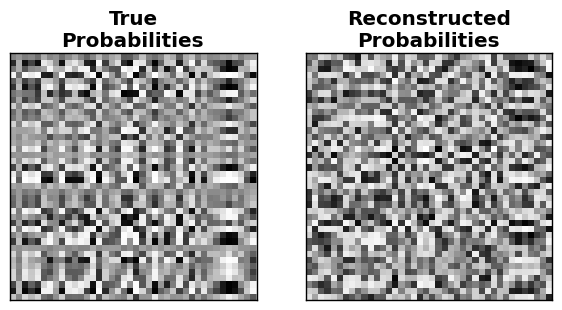

In [4]:
fMest = lgc(Mest.value)

# Plot the ground-truth vs our reconstruction
figure(figsize=(7,14))
subplot(1,2,1)
imshow(fM,cmap=ColorMap("Greys"),interpolation="None")
xticks([]),yticks([]),title("True\nProbabilities",fontweight="bold")

subplot(1,2,2)
imshow(fMest,cmap=ColorMap("Greys"),interpolation="None")
xticks([]),yticks([]),title("Reconstructed\nProbabilities",fontweight="bold")
show()

### It is kind of difficult to determine how well we did just by eye, so let's look at a histogram:

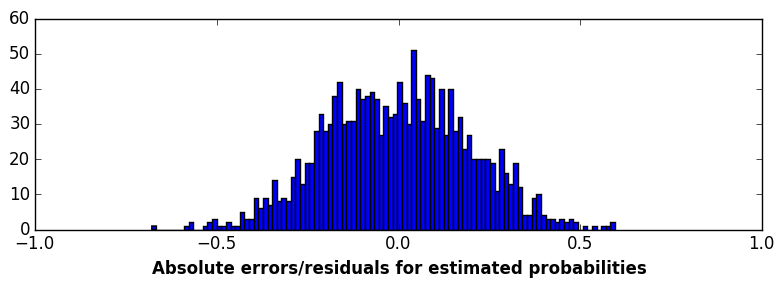

In [5]:
figure(figsize=(8,3))
PyPlot.hist(vec(fM-fMest),100)
xlim([-1,1]),xlabel("Absolute errors/residuals for estimated probabilities",fontweight="bold"),tight_layout()
show()

### Our estimate isn't perfect, since we have incomplete data and each data point is a noisy event.

### To get a sense of how good our estimate is, compute the [Hellinger distance](http://en.wikipedia.org/wiki/Hellinger_distance) between our estimate and the true probabilities. Then, compare this to how well we could do by randomly guessing the probabilities.

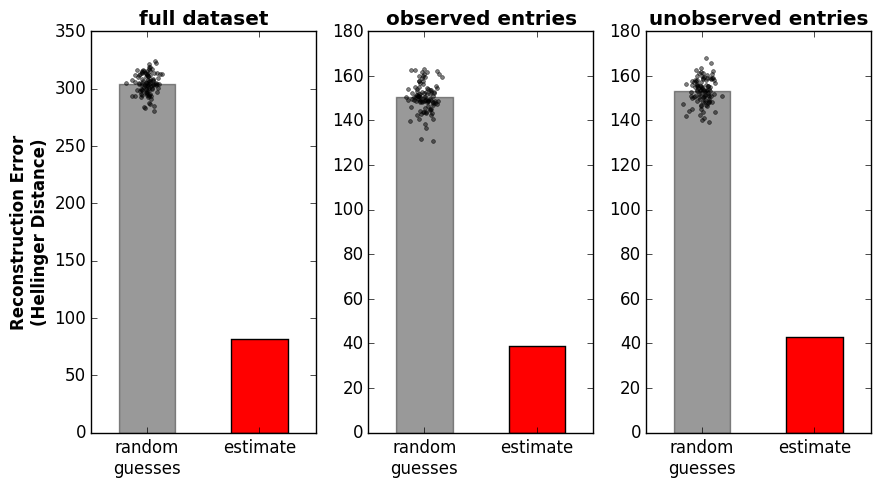

In [6]:
# Measure reconstruction error with Hellinger distance
function Hellinger_dist(p,q)
    return sum((sqrt(p)-sqrt(q)).^2 + (sqrt(1-p)-sqrt(1-q)).^2)
end

# Build a list of unobserved entries
not_obs = (Int64)[]
for i = 1:(m*n)
    if !(i in obs)
        push!(not_obs,i)
    end
end

nr = 100
rdf = zeros(nr) # random distribution of distances, full matrix
rdo = zeros(nr) # random distribution of distances, observed entries
rdu = zeros(nr) # random distribution of distances, observed entries
for a = 1:nr
    rdf[a] = Hellinger_dist(rand(m,n),fM)
    rdo[a] = Hellinger_dist(rand(m,n)[obs],fM[obs])
    rdu[a] = Hellinger_dist(rand(m,n)[not_obs],fM[not_obs])
end

function plot_error(rr,ind)
    bar(1,mean(rr),color="k",align="center",width=0.2,alpha=0.4)
    bar(1.4,Hellinger_dist(fMest[ind],fM[ind]),color="r",width=0.2,align="center")
    plot(1+0.025*randn(nr),rr,".k",alpha=0.5)
    xlim([0.8,1.6]), xticks([1,1.4],["random\nguesses","estimate"])
end

figure(figsize=(9,5))
subplot(1,3,1), plot_error(rdf,[1:(m*n)]), title("full dataset",fontweight="bold")
ylabel("Reconstruction Error\n(Hellinger Distance)",fontweight="bold")
subplot(1,3,2), plot_error(rdo,obs), title("observed entries",fontweight="bold")
subplot(1,3,3), plot_error(rdu,not_obs), title("unobserved entries",fontweight="bold")
tight_layout()